In [1]:
import glob
from pathlib import Path

import numpy as np

import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import (
    RocCurveDisplay,
    roc_curve,
    roc_auc_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
)

In [2]:
tp_fp_sequences_path = (
    Path("..") / "data" / "handcrafted-metadata" / "tp_fp_sequences.csv"
)
sequences_df = pd.read_csv(tp_fp_sequences_path, index_col=0)
# Only keep relevant columns
# TODO maybe work with Weather and TimeOfDay
sequences_df = sequences_df[
    [
        "Classification",
        "Duration",
        "Distance",
        "SubjectApproachType",
        "SubjectDescription",
        "Distraction",
        "Stage",
    ]
]
# Fix index prefix for join
sequences_df = sequences_df.set_index("data/sequences/" + sequences_df.index)

In [3]:
def plot_roc_curve(fpr, tpr, auc_score, ax, name):
    roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=auc_score)

    roc_display.plot(ax=ax, color="orange")
    # plt.plot(fpr, tpr, color='orange', label='ROC')
    roc_display.ax_.plot([0, 1], [0, 1], color="darkblue", linestyle="--")
    # plt.xlabel('False Positive Rate')
    # plt.ylabel('True Positive Rate')
    roc_display.ax_.set_title(f"Receiver Operating Characteristic (ROC) Curve: {name}")
    roc_display.ax_.legend()

In [4]:
FEATURES_COLUMNS_INDEXES = pd.RangeIndex.from_range(range(600))


def plot_roc_confusion_matrix(sequences_df: pd.DataFrame, pickle_file: Path, axes):
    features_df = pd.read_pickle(pickle_file)
    df = sequences_df.join(features_df)

    df["Alarm"] = df["Classification"] == "TP"

    # For each sample, get the highest feature/signal
    df["Activation"] = df[FEATURES_COLUMNS_INDEXES].max(axis=1)

    tp = df[df["Alarm"]]
    # get the lowest activation
    min_signal_activation = tp["Activation"].min()
    # this value will be used as the threshold
    print(f"min_signal_activation: {min_signal_activation}")

    # ROC Plot
    y_true = df["Alarm"].to_numpy(dtype=np.int32)
    y_scores = df["Activation"].to_numpy()

    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    # print(tpr)
    # print(fpr)
    # print(thresholds)
    auc_score = roc_auc_score(y_true, y_scores)
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]
    print("ROC threshold value is:", optimal_threshold)
    plot_roc_curve(fpr, tpr, auc_score, axes[0], name=pickle_file.name)

    # Imagine setting the prediction threshold to min_signal of the actual positive samples
    y_pred = (df["Activation"] >= min_signal_activation).to_numpy(np.int32)

    confusion_matrix_arr = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = confusion_matrix_arr.ravel()
    print(dict(TP=tp, FN=fn))
    print(dict(FP=fp, TN=tn))

    plt_confusion_matrix = ConfusionMatrixDisplay(
        confusion_matrix=confusion_matrix_arr, display_labels=["Noise", "Alarm"]
    )
    plt_confusion_matrix.plot(ax=axes[1])

#### movineta0.pkl
min_signal_activation: 2.9163434505462646
ROC threshold value is: 6.9736614
{'TP': 432, 'FN': 0}
{'FP': 432, 'TN': 0}
#### movineta1.pkl
min_signal_activation: 3.3909733295440674
ROC threshold value is: 5.8719096
{'TP': 432, 'FN': 0}
{'FP': 421, 'TN': 11}
#### movineta2.pkl
min_signal_activation: 3.792781114578247
ROC threshold value is: 291.65485
{'TP': 432, 'FN': 0}
{'FP': 430, 'TN': 2}
#### movineta3.pkl
min_signal_activation: 3.854766845703125
ROC threshold value is: 7.257403
{'TP': 432, 'FN': 0}
{'FP': 428, 'TN': 4}
#### movineta4.pkl
min_signal_activation: 3.868853807449341
ROC threshold value is: 1500.1578
{'TP': 432, 'FN': 0}
{'FP': 431, 'TN': 1}
#### movineta5.pkl
min_signal_activation: 3.8031625747680664
ROC threshold value is: 8883.069
{'TP': 432, 'FN': 0}
{'FP': 431, 'TN': 1}


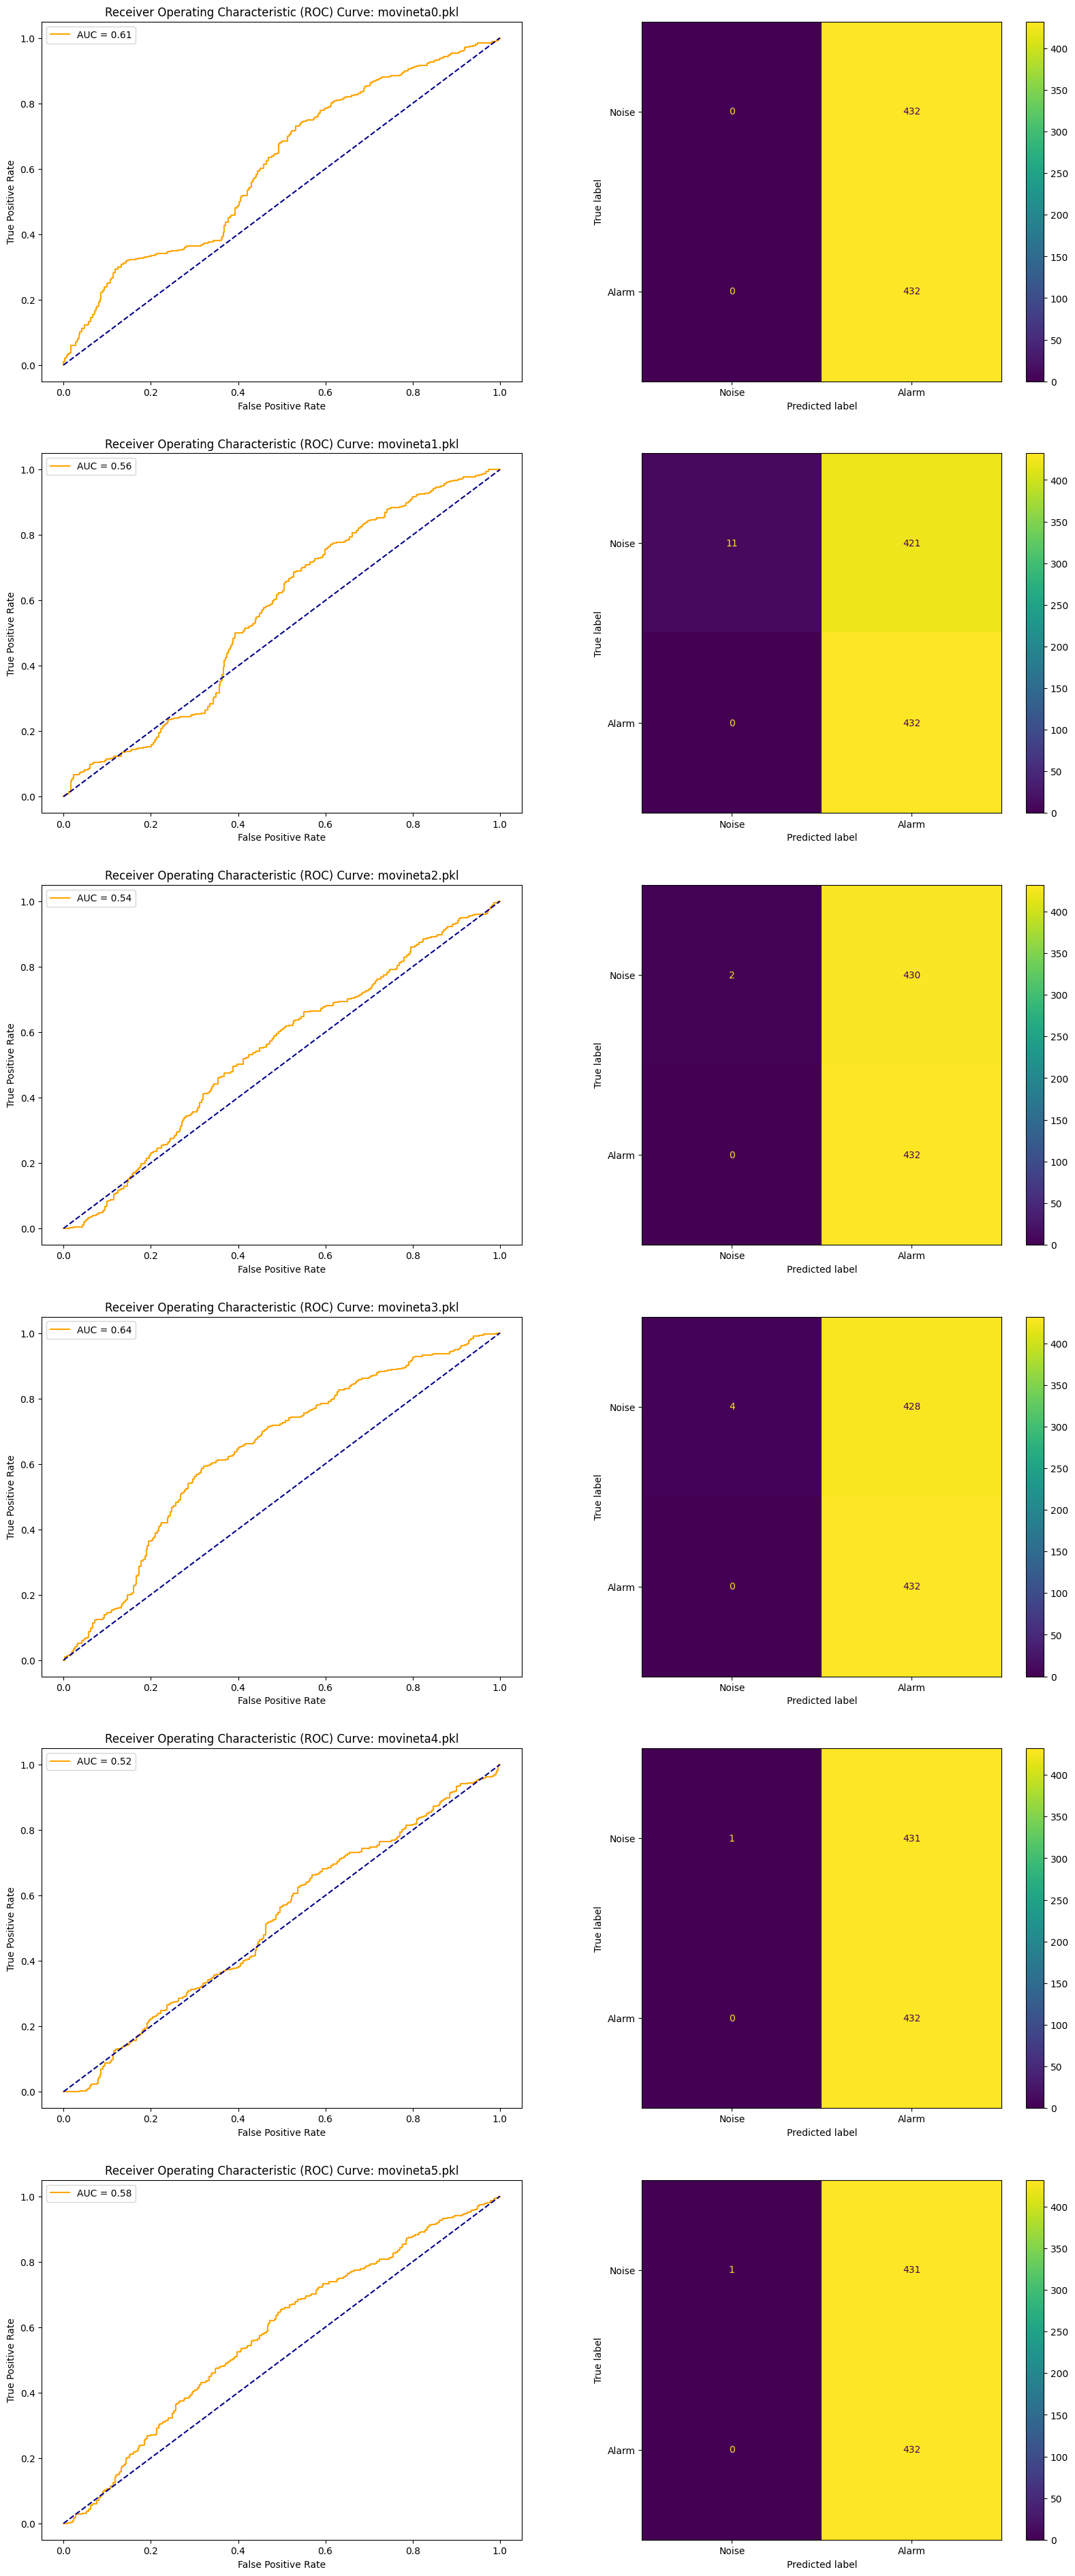

In [5]:
all_exp = sorted(glob.glob(str(Path("..") / "results" / "movinet" / "*.pkl")))

fig, axes = plt.subplots(len(all_exp), 2, figsize=(20, 48))

for file, row_axes in zip(all_exp, axes):
    print(f"#### {Path(file).name}")
    plot_roc_confusion_matrix(sequences_df, Path(file), row_axes)

plt.show()